# Identify sarcastic sentences with machine learning techniques

## Project Overview
This project can be used as a complete guide to EDA and machine learning technique for sentence classification tasks accompanied with advice for practioners. It will cover:

* Exploratory Data Analysis .
* Tokenizing and preprocessing from text data
* Loading pretrained Bert and creating a deep learning model for fine-tuning
* Building and training model with PyTorch on HuggingFace framework
* Advice for practitioners


## Problem statement

Sarcasm detection is a narrow field of study in NLP, whose goal is to determine if a sentence is satirical or non-sarcastic. Sarcasm is a kind of phenomenon that is common in social networks, newspapers and it has a specific effect on listeners, such as teasing some events, breaking their expectations mood. Thus, properly understanding irony often requires a deep understanding of multiple sources of information, including how it is stated, the context of the conversation, and often some real-world events.

In this project, we aim to answer the question whether we identify sarcastic sentences automatically using ML/DL technique ? How do these techniques apply in this case and their performance?

## Dataset
In this dataset, each record consists of three attributes:

* is_sarcastic: 1 if the record is sarcastic otherwise 0

* headline: the headline of the news article

* article_link: link to the original news article. Useful in collecting supplementary data

This dataset could be founded  in the Kaggle Dataset [news-headlines-dataset-for-sarcasm-detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection)

## Metrics 
In this project, we use performance metrics as precision, recall, and F1-Score. A binary classifier can be viewed as classifying instances as positive or negative:
* Positive: The instance is classified as a member of the class the classifier is trying to identify. For example, a classifier looking for cat photos would classify photos with cats as positive (when correct).

* Negative: The instance is classified as not being a member of the class we are trying to identify. For example, a classifier looking for cat photos should classify photos with dogs (and no cats) as negative.

The basis of precision, recall, and F1-Score comes from the concepts of True Positive, True Negative, False Positive, and False Negative

* Precision is a measure of how many of the positive predictions made are correc

* Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data. It is sometimes also referred to as Sensitivity.


* F1-Score is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean.

$F1_{Score} = 2*(Precision * Recall) / (Precision + Recall)$



### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Reading the data
The following code snippet could be used to read the data

In [ ]:
df = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
# Let's use regex on the "article_link" column to get the source data.
df["source"] = df["article_link"].apply(lambda string: re.findall('[a-zA-Z]+', string)[2] )
df = df.drop(['article_link'],axis = 1)


In [ ]:
df.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


## Preprocessing data

Let's clean the headline

In [ ]:
df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(lambda x: re.sub('[^a-zA-Z\s]+|X{2,}', '', x))

# [@\^&\*\$] matches on the characters, you want to replace
#\S+matches on hash tags
# \S+[a-z0-9]\.(com|net|org) matches on domain names

df['headline'] = df['headline'].apply(lambda x: re.sub("[@\^&\*\$]|#\S+|\S+[a-z0-9]\.(com|net|org)"," ",x))


Let's expanding contractions 
by using the contractions_dict, credit to [DEVANSHI PATEL ](https://https://www.kaggle.com/devanshiipatel/eda-and-sentiment-analysis)

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
df['headline'] = df['headline'].apply(lambda x:expand_contractions(x))

In [ ]:
df['CharCount'] = df['headline'].apply(lambda x: len(x))
df['WordCount'] = df['headline'].apply(lambda x: len(x.split()))

In [ ]:
df.head(10)

,is_sarcastic,headline,source,CharCount,WordCount
0,1,thirtysomething scientists unveil doomsday clo...,theonion,61,8
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,77,13
2,0,eat your veggies deliciously different recipes,huffingtonpost,47,6
3,1,inclement weather prevents liar from getting t...,theonion,52,8
4,1,mother comes pretty close to using word stream...,theonion,59,9
5,0,my white inheritance,huffingtonpost,20,3
6,0,ways to file your taxes with less stress,huffingtonpost,41,8
7,1,richard bransons globalwarming donation nearly...,theonion,86,13
8,1,shadow government getting too large to meet in...,theonion,73,12
9,0,lots of parents know this scenario,huffingtonpost,34,6


In [ ]:
df["source"].value_counts()

huffingtonpost    14985
theonion          13634
Name: source, dtype: int64

In [ ]:
df["is_sarcastic"].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

## Visualization

### Length of sentence Distribution


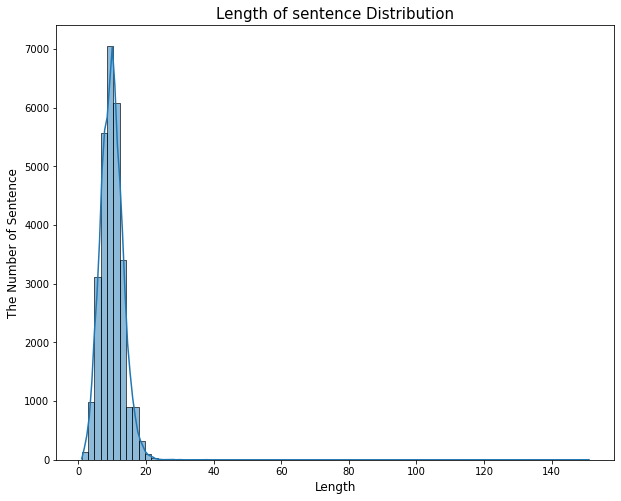

In [ ]:
plt.figure(figsize = (10, 8))
plt.title('Length of sentence Distribution', fontsize=15)
plt.xlabel("Length", fontsize=12)
plt.ylabel("The Number of Sentence", fontsize=12)

sns.histplot(df, x='WordCount',
             kde = True, 
             bins = 80
             )

In [ ]:
fig = px.histogram(df['WordCount'], color=df['is_sarcastic'],
                   labels={'value': 'WordCount', 'color': 'is_sarcastic'}, 
                   color_discrete_map={0: "skyblue", 1: "gray"},
                   marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the sentence length and sarcastic	',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

Text(0, 0.5, 'The Number of label')

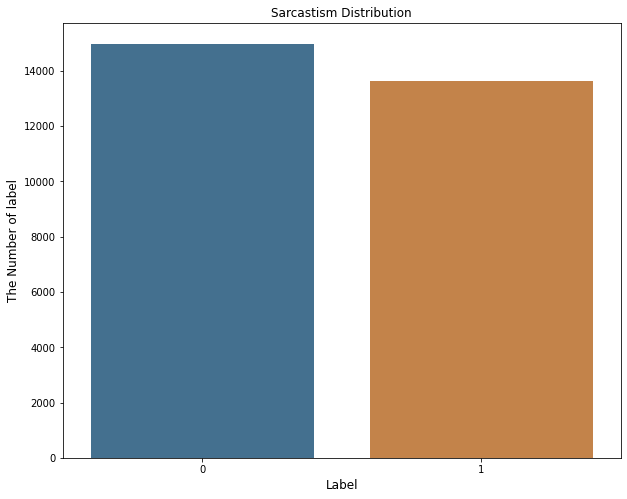

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(x = df.is_sarcastic, data = df, saturation=0.5)
plt.title('Sarcastism Distribution', fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.ylabel("The Number of label", fontsize=12)


From the above figure, we can observe that
* The dataset is quiet balance
* The distribution of sarcastic sentences and not sarcastic sentences is quite similar.

Text(0, 0.5, 'Count')

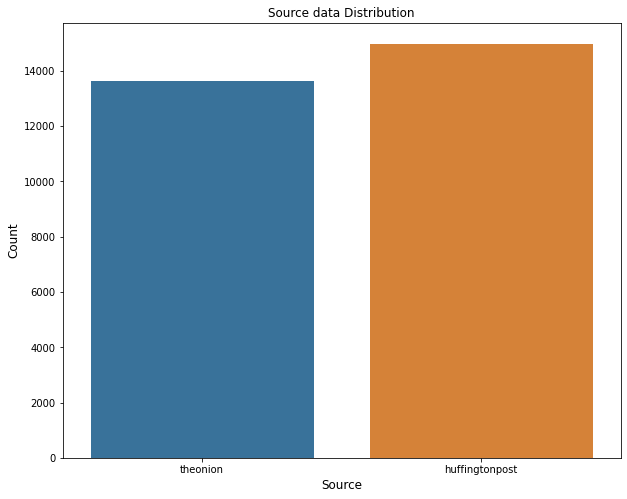

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(x = df.source, data = df, saturation=0.65)
plt.title('Source data Distribution', fontsize=12)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Count", fontsize=12)


In [ ]:
def get_top_nwords(x, n, i):
    vec = CountVectorizer(ngram_range=(i,i)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# Bigram
words = get_top_nwords(df.headline, 20, 2) 
df_bi = pd.DataFrame(words, columns=['Bigram', 'Frequency'])
df_bi.head()

,Bigram,Frequency
0,donald trump,366
1,of the,365
2,in the,360
3,to be,355
4,out of,268


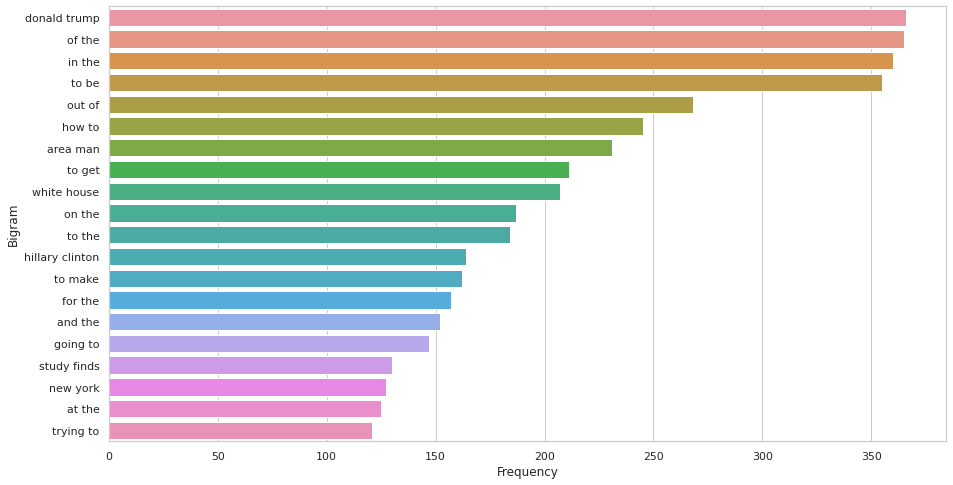

In [ ]:
plt.figure(figsize = (15, 8))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y='Bigram', x='Frequency', orient = "h", data=df_bi)

### Generating WordClouds

We use Word Cloud, which is a data visualization technique, to represent text data in different size of each word corresponding to its frequency or importance. In this project, we use the library wordcloud For generating word cloud in Python.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

There are 1769716 words in the combination of headlines.


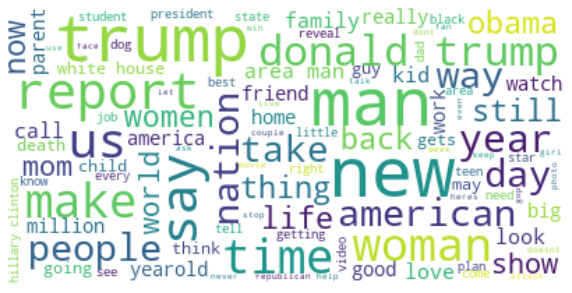

In [ ]:
# Wordcloud 
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["one", "first", "will", "want", "give"])


texts = " ".join(text for text in df.headline)
print ("There are {} words in the combination of headlines.".format(len(texts)))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      stopwords=stopwords,
                      background_color="white").generate(texts)

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("first_review.png")

As you can see, the most frequent words in this dataset are about Donald Trump, nation, American, report...So we can guess that people tends to make sarastic sentences about politics (Donald Trump, nation, American)

## Machine Learning Algorithm

### Tokenizer


In [ ]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [ ]:
X = df.headline
Y = df.is_sarcastic
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
import nltk
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### RandomForest

In [ ]:
# Instantiate transformers and classifier
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier()


# Fit and/or transform each to the training data
# Hint: you can use the fit_transform method
X_train_counts = vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_counts)

# Fit or train the classifier
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [ ]:
# Transform test data
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

# Predict test labels
y_pred = clf.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4916
           1       0.80      0.79      0.80      4529

    accuracy                           0.81      9445
   macro avg       0.81      0.81      0.81      9445
weighted avg       0.81      0.81      0.81      9445



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8050759493875559

###  Gaussian Naive Bayes model

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train_tfidf.toarray(), y_train)


# Predict test labels
y_pred = model.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      4916
           1       0.74      0.46      0.57      4529

    accuracy                           0.67      9445
   macro avg       0.69      0.66      0.65      9445
weighted avg       0.69      0.67      0.65      9445



In [ ]:
roc_auc_score(y_test, y_pred)

0.6590592791307299

### SVM

In [ ]:
from sklearn import svm

In [ ]:
model = svm.SVC(kernel='linear', gamma=1) 

# Train the model using the training sets
model.fit(X_train_counts, y_train)

# Predict test labels
y_pred = model.predict(X_test_counts.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4916
           1       0.82      0.80      0.81      4529

    accuracy                           0.82      9445
   macro avg       0.82      0.82      0.82      9445
weighted avg       0.82      0.82      0.82      9445



In [ ]:
roc_auc_score(y_test, y_pred)

0.8213223263657892

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)

# Train the model using the training sets
knn.fit(X_train_tfidf.toarray(), y_train)

# Predict test labels
y_pred = knn.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      4916
           1       0.72      0.61      0.66      4529

    accuracy                           0.70      9445
   macro avg       0.70      0.70      0.69      9445
weighted avg       0.70      0.70      0.70      9445



In [ ]:
roc_auc_score(y_test, y_pred)

0.6952731479493602

### BERT
Bidirectional Encoder Representations from Transformers (BERT) is a state of the art model based on transformers developed by google. It can be pre-trained and later fine-tuned for a specific task. We will fine-tune bert on a classification task. 

Bert was trained on two tasks simultaneously
* Masked language modelling (MLM) — 15% of the tokens were masked and was trained to predict the masked word
* Next Sentence Prediction(NSP) — Given two sentences A and B, predict whether B follows A

The framework [HugggingFace](https://huggingface.co/docs/transformers/index) provides us a shortcut to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you time from training a model from scratch. In this project, we choose to fine-tune the TinyBert due to the limited hardware GPU for a classification task

Now, let's use it on the Sacratic Dataset.

In [ ]:
!pip install transformers==4.12

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.2 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 596 kB 42.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):

        self.labels = np.array(Y)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512,
                                # truncation=True,
                                return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, X,Y, learning_rate, epochs, batch_size):

    train = Dataset(X,Y)
    # , Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
           
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(X): .3f} | Train Accuracy: {total_acc_train / len(X): .3f}')
                  

In [ ]:
def evaluate(model, X,Y, batch_size):

    test = Dataset(X, Y)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1))

    return y_pred


In [ ]:
EPOCHS = 5
batch_size = 32
model = BertClassifier()
LR = 1e-4
              
train(model, X_train, y_train, LR, EPOCHS, batch_size)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 600/600 [01:06<00:00,  8.99it/s]


Epochs: 1 | Train Loss:  0.013 | Train Accuracy:  0.803


100%|██████████| 600/600 [01:02<00:00,  9.57it/s]


Epochs: 2 | Train Loss:  0.008 | Train Accuracy:  0.906


100%|██████████| 600/600 [01:09<00:00,  8.62it/s]


Epochs: 3 | Train Loss:  0.004 | Train Accuracy:  0.958


100%|██████████| 600/600 [01:08<00:00,  8.79it/s]


Epochs: 4 | Train Loss:  0.002 | Train Accuracy:  0.982


100%|██████████| 600/600 [01:03<00:00,  9.49it/s]


Epochs: 5 | Train Loss:  0.001 | Train Accuracy:  0.991


In [ ]:
y_pred = evaluate(model, X_test,y_test, batch_size)

In [ ]:
y_pred_ = torch.cat(y_pred, dim=0)

In [ ]:
y_pred_=y_pred_.cpu().detach().numpy()

In [ ]:
print(classification_report(y_test.values, y_pred_))
print(roc_auc_score(y_test, y_pred_))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4916
           1       0.88      0.84      0.86      4529

    accuracy                           0.87      9445
   macro avg       0.87      0.86      0.87      9445
weighted avg       0.87      0.87      0.87      9445

0.8645351195738663


## Mdel Performance Comparaison

We recap the performance of these machine learning models on the following table.

| **Model** | **Precision** | **Recall** | **Accuracy** | **F1 Score** | **AUC** |
|---|---|---|---|---|---|
| Random Forest | 0.810 | 0.810 | 0.810 | 0.810 | 0.805 |
| Gaussian Naive   Bayes | 0.690 | 0.660 | 0.670 | 0.650 | 0.659 |
| SVM | 0.820 | 0.820 | 0.820 | 0.820 | 0.821 |
| KNN | 0.700 | 0.700 | 0.700 | 0.690 | 0.695 |
| TinyBert | _0.870_ | _0.860_ | _0.870_ | _0.870_ | _0.864_ |

As you can see, TinyBert has the better performance in comparaison with other techniques such as Random Forest, Gaussian Naive Bayes, SVm, KNN.

## Summary

* The dataset is quiet balance
* The distribution of sarcatic sentences and not sarcatic sentences is quite similar.
* The most frequent words in this dataset are about Donald Trump, nation, American, report
* TinyBert has the better performance in comparaison with other techniques such as Random Forest, Gaussian Naive Bayes, SVm, KNN.

## Acknowledgment 
Thanks Udacity for great project.

Thanks to [Rishabhmisra](https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection) for this dataset as well as his below research.

* Misra, R., & Grover, J. (2021). Sculpting Data for ML: The first act of Machine Learning.

* Misra, R., & Arora, P. (2019). Sarcasm detection using hybrid neural network. arXiv preprint arXiv:1908.07414.

